In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print('Before data cleaning and feature engineering:')
print('Number of null elements in Train Set: ', sum(sum(train.isnull().values)))
print('Number of null elements in Test Set: ', sum(sum(test.isnull().values)))

Before data cleaning and feature engineering:
Number of null elements in Train Set:  6965
Number of null elements in Test Set:  7000


In [4]:
# Obtaining list of numerical columns
num_cols = train._get_numeric_data().columns
num_cols = num_cols.delete([0,len(num_cols)-1]) # Deleting ID and SalePrice (target variable)

# Decreasing skewness of the features

In [5]:
feat_skewness = train[num_cols].apply(lambda x: skew(x.dropna()))
feat_skewness = feat_skewness[abs(feat_skewness) > 0.75] # Selecting highly skewed features

for df in (train, test):
    df.loc[:,num_cols] = df[num_cols].apply(lambda x: np.log1p(x.dropna()))

In [6]:
feat_skewness_improved = train[num_cols].apply(lambda x: skew(x.dropna()))
feat_skewness_improved[abs(feat_skewness_improved) > 0.75]

BsmtFinSF2        2.521100
BsmtUnfSF        -2.184257
TotalBsmtSF      -5.149373
LowQualFinSF      7.452650
BsmtHalfBath      3.929022
BedroomAbvGr     -1.232409
KitchenAbvGr      3.865437
GarageCars       -1.368811
GarageArea       -3.479025
EnclosedPorch     2.110104
3SsnPorch         7.727026
ScreenPorch       3.147171
PoolArea         14.348342
MiscVal           5.165390
MoSold           -0.912485
dtype: float64

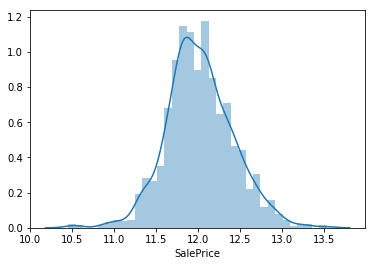

In [7]:
train.loc[:,'SalePrice'] = np.log1p(train['SalePrice'].dropna())
g = sns.distplot(train['SalePrice'])

# Imputing numerical features

In [8]:
def impute_numer(df):
    num_cols = df._get_numeric_data().columns
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imputer = imputer.fit(df.loc[:, num_cols])
    df.loc[:, num_cols] = imputer.transform(df.loc[:, num_cols])
    return df

In [9]:
train = impute_numer(train)
test = impute_numer(test)

# Imputing categorical features

In [18]:
def impute_categor(train, test):
    str_cols = train.dtypes[train.dtypes == 'object'].index.values
    
    str_cols = np.append(str_cols, 'MSSubClass') # See the MSSubClass barplot in the EDA file 
    train['MSSubClass'] = train['MSSubClass'].apply(lambda x: str(x))
    test['MSSubClass'] = test['MSSubClass'].apply(lambda x: str(x))
    
    for col in str_cols:
        train[col].fillna('none', inplace = True)
        test[col].fillna('none', inplace = True)
        
        imputing_number = 1
        categories_sorted = train.groupby([col])['SalePrice'].sum().sort_values().index.values
        if 'none' not in categories_sorted:
            categories_sorted = np.insert(categories_sorted,0,'none') # Test categorical values can 
                                                                      # slightly differ from the train ones
        for category in categories_sorted:
            train.loc[train[col]  == category, col] = imputing_number
            test.loc[test[col]  == category, col] = imputing_number
            imputing_number += 1
    return train, test

In [19]:
train, test = impute_categor(train, test)

# Features Scaling

In [13]:
scaler = StandardScaler()

train_cols_to_scale = train.columns.delete([0,train.shape[1]-1]) # Deleting ID and SalePrice (target variable)
train[train_cols_to_scale] = scaler.fit_transform(train[train_cols_to_scale])

test_cols_to_scale = test.columns.delete(0) # Deleting ID
test[test_cols_to_scale] = scaler.fit_transform(test[test_cols_to_scale])

# Feature Engineering Results

In [20]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,15,6,4.189655,9.042040,3,3,5,5,3,...,0.0,4,5,5,0.0,1.098612,7.605392,10,7,12.247699
1,2.0,16,6,4.394449,9.169623,3,3,5,5,3,...,0.0,4,5,5,0.0,1.791759,7.604894,10,7,12.109016
2,3.0,15,6,4.234107,9.328212,3,3,4,5,3,...,0.0,4,5,5,0.0,2.302585,7.605392,10,7,12.317171
3,4.0,10,6,4.110874,9.164401,3,3,4,5,3,...,0.0,4,5,5,0.0,1.098612,7.604396,10,5,11.849405
4,5.0,15,6,4.442651,9.565284,3,3,4,5,3,...,0.0,4,5,5,0.0,2.564949,7.605392,10,7,12.429220


In [15]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461.0,-1.116585,-3.596122,0.640480,0.561787,0.06426,0.264086,0.703009,0.310969,0.03705,...,2.844271,-0.063967,0.043675,-0.919649,0.176882,-0.188227,0.162759,1.713372,0.295066,0.393203
1,1462.0,-1.116585,0.463776,0.678094,0.970407,0.06426,0.264086,-1.090156,0.310969,0.03705,...,-0.324992,-0.063967,0.043675,0.434304,-8.722107,7.333230,0.162759,1.713372,0.295066,0.393203
2,1463.0,0.414449,0.463776,0.404558,0.908413,0.06426,0.264086,-1.090156,0.310969,0.03705,...,-0.324992,-0.063967,0.043675,-0.919649,0.176882,-0.188227,-1.100777,1.713372,0.295066,0.393203
3,1464.0,0.414449,0.463776,0.563839,0.257857,0.06426,0.264086,-1.090156,0.310969,0.03705,...,-0.324992,-0.063967,0.043675,0.434304,0.176882,-0.188227,0.162759,1.713372,0.295066,0.393203
4,1465.0,1.397832,0.463776,-1.230253,-1.116969,0.06426,0.264086,-1.090156,-3.100336,0.03705,...,2.963846,-0.063967,0.043675,0.434304,0.176882,-0.188227,-2.665809,1.713372,0.295066,0.393203


In [16]:
test['Id'] = test['Id'].apply(lambda x: int(x))

In [17]:
print('After data cleaning and feature engineering:')
print('Number of null elements in Train Set: ', sum(sum(train.isnull().values)))
print('Number of null elements in Test Set: ', sum(sum(test.isnull().values)))

After data cleaning and feature engineering:
Number of null elements in Train Set:  0
Number of null elements in Test Set:  0


In [18]:
train.dtypes.values

array([dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'),

All features in the train set have numerical values

In [19]:
test.dtypes.values

array([dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), d

All features in the test set have numerical values

# Saving prepared for model building data

In [20]:
train.to_csv('data/train_cleaned.csv', index=False)
test.to_csv('data/test_cleaned.csv', index=False)